In [1]:
import os
import random
import numpy as np
import pandas as pd

import albumentations as A
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cases = "train"

data_list = pd.read_csv(f'/data/komedi/backup/dataset/versioning/22-07-15-1600-{cases}-no300w.csv',header=None).values.tolist()
print(len(data_list))

1781


In [3]:
# data_list = pd.read_csv('/data/komedi/dataset/versioning/22-07-15-1600-valid-no300w.csv',header=None).values.tolist()
# print(len(data_list))

In [4]:
if cases == "train":
    aug_list = {
                "rotate15":A.Rotate((15,15),always_apply=True),
                "rotate30":A.Rotate((30,30),always_apply=True),
                "rotate45":A.Rotate((45,45),always_apply=True),
                "rotate60":A.Rotate((60,60),always_apply=True),
                "rotate75":A.Rotate((75,75),always_apply=True),
                "rotate90":A.Rotate((90,90),always_apply=True),
                "rotate_15":A.Rotate((-15,-15),always_apply=True),
                "rotate_30":A.Rotate((-30,-30),always_apply=True),
                "rotate_45":A.Rotate((-45,-45),always_apply=True),
                "rotate_60":A.Rotate((-60,-60),always_apply=True),
                "rotate_75":A.Rotate((-75,-75),always_apply=True),
                "rotate_90":A.Rotate((-90,-90),always_apply=True),  
                "horizontal":A.HorizontalFlip(always_apply=True),
                "resizecrop":A.RandomResizedCrop(112,112,scale=(0.3,1.0),always_apply=True),
                "affine1": A.Affine(scale=(0.5,1),shear=(-45),always_apply=True),
                "affine2": A.Affine(scale=(0.5,1),shear=(-15,15),always_apply=True),
                "affine3": A.Affine(scale=(0.5,1),shear=(15,45),always_apply=True),
                "affine4": A.Affine(scale=(1,1.5),shear=(-45,-15),always_apply=True),
                "affine5": A.Affine(scale=(1,1.5),shear=(-15,15),always_apply=True),
                "affine6": A.Affine(scale=(1,1.5),shear=(15,45),always_apply=True),                
                "rotate":A.Rotate(always_apply=True),
                "affine7": A.Affine(scale=(1.5,2.0),shear=(-45,-15),always_apply=True),
                "affine8": A.Affine(scale=(1.5,2.0),shear=(-15,15),always_apply=True),
                "affine9": A.Affine(scale=(1.5,2.0),shear=(15,45),always_apply=True),
                "shiftscalerotate":A.ShiftScaleRotate(border_mode=1, always_apply=True),
                "normal":None,
                "huesaturate":A.HueSaturationValue(always_apply=True),
                "gausianblur":A.GaussianBlur(p=0.5),
                "gaussnoise":A.GaussNoise(always_apply=True),
                "clahe":A.CLAHE(always_apply=True),
                "imagecomp":A.ImageCompression(always_apply=True),
                "randomgamma":A.RandomGamma(always_apply=True),
                "posterize":A.Posterize(always_apply=True),
                "blur":A.Blur(always_apply=True),
                "colorjitter":A.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
                "bright":A.RandomBrightnessContrast(contrast_limit=0.5,brightness_limit=0.5,p=0.2)
                }
    print(len(aug_list.keys()))
else:
    aug_list = {"normal":None}

for dir in aug_list.keys():
    os.makedirs(f"/data/komedi/dataset/{cases}/{dir}",exist_ok=True)

36


In [24]:
from tqdm import tqdm
csv_lists = []
for idx, data in enumerate(tqdm(data_list)):
    # if idx>=10:
    #     break
    image_name = data[0]

    margin = 200
    crop_area = (data[4]-margin//2,
                    data[5]-margin//2,
                    data[6]+margin//2,
                    data[7]+margin//2)
    
    pil_image = Image.open(data[3])
    crp_image = pil_image.crop(crop_area)

    npy_image = np.array(crp_image)

    label = []
    for landmark in data[8:]:
        x,y = eval(landmark[1:-1])
        label.append([x,y])
    lst_label = np.array(label)

    for types in aug_list.keys():
        csv_list = []
        if not aug_list[types]:                    
            out_image = npy_image
            out_label = lst_label    
        else:
            transform = A.Compose([
                aug_list[types]],
                keypoint_params = A.KeypointParams(format="xy",remove_invisible = False))

            transformed = transform(image=npy_image, keypoints=lst_label)
            aug_image = transformed['image']
            aug_label = transformed['keypoints']

            out_image = aug_image
            out_label = aug_label
            
        image = Image.fromarray(out_image)
        image.save(f"/data/komedi/dataset/{cases}/{types}/{image_name}")

        csv_list.append(image_name) # 0
        csv_list.append(data[1]) # type(aflw) # 1
        csv_list.append(f"/data/komedi/dataset/{cases}/{types}/{image_name}") # 2
        for i in (4,5,6,7): #
            csv_list.append(data[i]) # bbox
        # csv_list.append(-30+data[7]) #pitch
        # csv_list.append(data[8]) #yaw
        # csv_list.append(data[9]) #roll
        for label in out_label:
            x,y = label
            csv_list.append((int(x),int(y)))
        csv_lists.append(csv_list)
        
    # random.shuffle(csv_lists)
    df = pd.DataFrame(csv_lists)
    df.to_csv(f"/data/komedi/dataset/versioning/22-07-20-1600-{cases}.csv",header=None, index=None)
print(len(csv_lists))


100%|██████████| 1781/1781 [42:00<00:00,  1.42s/it]

64116


In [12]:
data[7]

(261, 254)

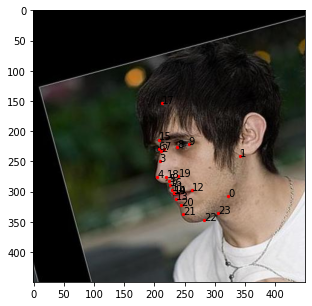

In [23]:
data = csv_lists[0]
image = Image.open(data[2])
crop_img = image.crop((data[3]-100,
                       data[4]-100,
                       data[5]+100,
                       data[6]+100))

plt.figure(figsize=(5,5))
for idx, landmark in enumerate(data[10:]):
    # print(landmark)
    # break
    x,y = landmark
    plt.scatter(x,y,s=5,c='r')
    plt.annotate(idx, (x,y))
plt.imshow(image)


In [ ]:
# random.shuffle(data_list)
"""
0: name
1 : type(kface, ibug, aflw2000)
2: image path
3 ~ 6: bbox value(lx, ly, rx, ry)
10 ~ 37: facial landmark 
"""

idx = 16
data = data_list[idx]
image = Image.open(data[2]).crop((data[3]-100,data[4]-100,data[5]+100,data[6]+100))
image = np.array(image)
plt.figure(figsize=(5,5))
plt.imshow(image)
label = []
for idx, landmark in enumerate(data[10:]):
    x,y = eval(landmark[1:-1])
    plt.scatter(x,y,s=5,c='r')
    plt.annotate(idx, (x,y))
    label.append([x,y])
label = np.array(label)
print(data[0])

In [ ]:
transform_list = []
transform = A.Compose([
    A.HorizontalFlip(always_apply=True)
],keypoint_params = A.KeypointParams(format="xy",remove_invisible = False))

In [ ]:
transformed = transform(image=image, keypoints=label)
aug_image = transformed['image']
aug_label = transformed['keypoints']

In [ ]:
pil_image = Image.fromarray(aug_image)

plt.figure(figsize=(8,8))
plt.imshow(pil_image)
for landmark in aug_label:
    x,y = landmark
    plt.scatter(x,y,s=5,c='r')